# Callibration esp32
données: "Data/Caractérisation adc Esp32 0dB"

L'adc de l'esp32 (à 0 dB d'atténuation) est caractérisé avec 15 échantillons uniforméments répartis entre 0 et 1205 mV. Un temps d'acquisition de 10 secondes avec un fréquence d'échantillonage de 6000 Hz est utilisé pour maximiser la précision des mesures.


D'abord, le bruit est caractérisé. Cette notion est ensuite utilisé pour choisir la plage de valeurs d'acquisition valide (sans saturation). Les points contenant de la saturation sont donc exclus. Finalement, une droite de régression est utilisé pour convertir les valeurs en tension et le coefficient R^2 est obtenue.


## Traitement des données brutes

Note: dans le code, l'array `freqs` fait référence à la tension mesuré au multimètre et non pas à la fréquence. La raison est que l'interface à été utilisé pour l'acquisition et en considérant les fréquences comme la tension de référence, c'était plus simple.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


with open("Data/Caractérisation adc Esp32 0dB/info.txt") as fich:
    info = fich.read()

info = info.split('\n')
nbrePts = info[4]
nbrePts = int(nbrePts.split()[3])
plagefreq = info[3].split()
freqMin = float(plagefreq[3][1:-1])
freqMax = float(plagefreq[4][:-1])
freqs = np.linspace(freqMin, freqMax, nbrePts)

samplingRate = float(info[5].split()[1])

samplingTime = float(info[2].split()[3])


sequencesList = []

for f in freqs:
    f = int(f)
    filename = f"Data/Caractérisation adc Esp32 0dB/{f} Hz.txt"
    with open(filename,'r') as fich:
        seq = fich.read()
    
    sequencesList.append(seq)

freqs = np.array([0.0, 85.9, 172, 258, 343.9, 430, 516, 602, 688, 774, 860, 946, 1032, 1118, 1205])

DATA = []
for seq in sequencesList:
    data = seq.split('\n\n')[-1]
    data = data.split()
    data = data[1:-1]
    data = [[(int(n) if n else None) for n in i.split(',')] for i in data]

    for i in data:
        if len(i) != 3:
            data.remove(i)

    data = np.array(data)
    DATA.append(data)

    index = np.array(data)[:,0]


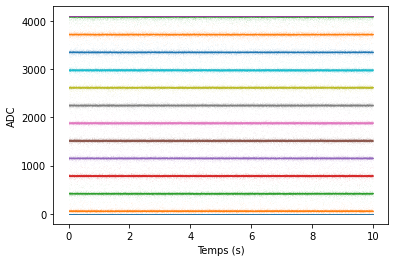

Signaux ADC des 15 tests en fonction du temps


In [2]:
samplingTime = 10
N = int(samplingTime*samplingRate)
V = []
eV = []

I = []
eI = []
for i in DATA:
    t = np.linspace(0, samplingTime, N)
    courant = i[-N:,2]
    #plt.plot(t, courant)
    tension = i[-N:,1]


    plt.scatter(t, tension, alpha=0.1, s=0.01)
    
    V += [np.mean(tension)]
    eV += [np.std(tension)]
    I += [np.mean(courant)]
    eI += [np.std(courant)]

# plt.plot([0,samplingTime], [0,0], 'k:')
# plt.plot([0,samplingTime], [4095,4095], 'k:')

plt.xlabel("Temps (s)")
plt.ylabel("ADC")
plt.show()
print('Signaux ADC des 15 tests en fonction du temps')


V = np.array(V)
eV = np.array(eV)
I = np.array(I)
eI = np.array(eI)

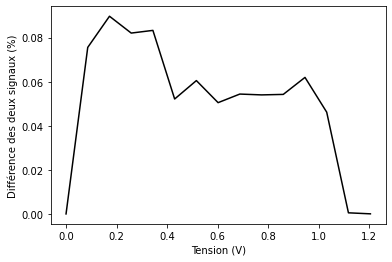

Différence des signaux entre les 2 cannaux en %. 
Comme c'est petit, on va considérer que le comportemnt est le même.


In [3]:

plt.plot(freqs/1000, np.abs((V-I))/np.mean([V,I])*100, "k")
plt.xlabel("Tension (V)")
plt.ylabel("Différence des deux signaux (%)")
plt.show()
print("Différence des signaux entre les 2 cannaux en %. \nComme c'est petit, on va considérer que le comportemnt est le même.")

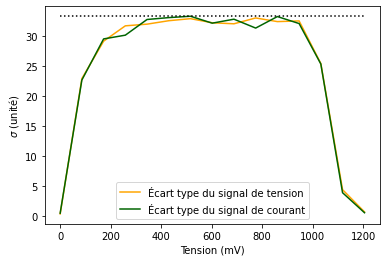

Écart type en fonction de la tension. sigmma_max = 33.3 unités


In [4]:
plt.plot(freqs, eV, 'orange', label='Écart type du signal de tension')
plt.plot(freqs, eI, 'darkgreen', label='Écart type du signal de courant')
errorMax = np.max([eV, eI])
plt.plot(freqs, freqs*0+errorMax, 'k:')
plt.xlabel("Tension (mV)")
plt.ylabel("$\sigma$ (unité)")
plt.legend()
plt.show()
print(f'Écart type en fonction de la tension. sigmma_max = {errorMax:.1f} unités')


# Plage de tension valide sans saturation:
Si on veut 99.7% des données, on choisis $3\sigma_{max}$ comme marge.

In [5]:
marge = int(3*errorMax+1)
print(f'Marge: {marge} unités')
print(f"Plage valide: [{marge}; {4095-marge}] unités")

Marge: 100 unités
Plage valide: [100; 3995] unités


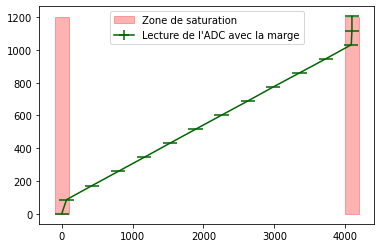

Zone de saturation de l'ADC. Les 2 premiers points et les 3 derniers sont donc exclus de l'analyse


In [6]:
plt.errorbar(V, freqs, 1, marge, 'darkgreen', label="Lecture de l'ADC avec la marge")
plt.fill_between([-100,100], [1200, 1200], color='red', alpha=0.3, label = "Zone de saturation")
plt.fill_between([3995,4195], [1200, 1200], color='red', alpha=0.3)
plt.legend(loc='upper center')
plt.show()
print("Zone de saturation de l'ADC. Les 2 premiers points et les 3 derniers sont donc exclus de l'analyse")

# Régression linéaire:

In [7]:
from scipy.stats import linregress

x = V[2:-3]
y = freqs[2:-3] #UTILISÉ LES VRAIS VALEURS

slope, intercept, r_value, p_value, std_err = linregress(x,y)

def adc2V(adc):
    return slope*adc + intercept

print(f"Modèle: V = {slope:.5f}*ADC + {intercept:.3f}\nR^2: {r_value**2}")

Modèle: V = 0.23501*ADC + 71.669
R^2: 0.9999940572082667


In [8]:
print(f"Plage de tension valide: {adc2V(marge):.1f} à {adc2V(4095-marge):.0f} mV")
print(f"Écart-type sur une mesure: {errorMax*slope:.2f} mV") # comme c'est un écart l'ordonnée à l'origine n'est pas prise en compte dans la conversion.

Plage de tension valide: 95.2 à 1011 mV
Écart-type sur une mesure: 7.81 mV


# Résultats:

$V = 0.23501 \cdot ADC_{val} + 71.669$

$R^2 = 0.999994$ (on note que les valeurs ont été moyennées sur 60000 mesures ici.)

Écart-type sur une mesure: $\sigma = 7.81$ mV

Valide de 96 à 1011 mV

